In [ ]:
import pickle
import os
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
import kagglehub
import pandas as pd
import numpy as np

In [ ]:
path = kagglehub.dataset_download("tisdang/pps-data")
print("Path to dataset files:", path)

100%|██████████| 249M/249M [00:02<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tisdang/pps-data/versions/5


In [ ]:
llm_path = os.path.join(path, 'llm')

# Load data
with open(os.path.join(llm_path, 'train_data.pkl'), 'rb') as f:
    train_data = pickle.load(f)

print(train_data.head())

                                                    text  labels
25372  In the time since Justice Antonin Scalia’s pas...       1
17129  Rachel Dolezal, a former NAACP leader and prof...       1
45695  PARIS  —   At the end of the Jean Paul Gaultie...       1
56576  A Catholic apple grower in Michigan has been b...       1
18184  Iraqi forces are about to launch an offensive ...       1


In [ ]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 47169 entries, 25372 to 36288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47154 non-null  object
 1   labels  47169 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


In [ ]:
# Check null values
print("number of null rows in train set:", train_data['text'].isnull().sum())

# Drop null
train_data = train_data.dropna(subset=['text'])

number of null rows in train set: 15


## **Label distribution**

In [ ]:
print(train_data['labels'].value_counts())

labels
0    26145
1    21009
Name: count, dtype: int64


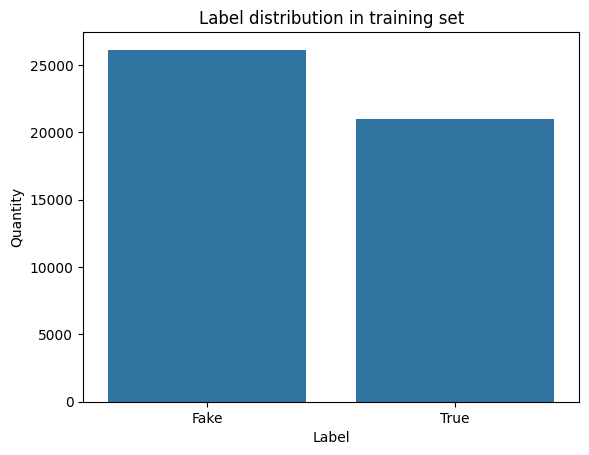

In [ ]:
sns.countplot(x='labels', data=train_data)
plt.xticks([0, 1], ['Fake', 'True'])
plt.title('Label distribution in training set')
plt.xlabel('Label')
plt.ylabel('Quantity')
plt.show()


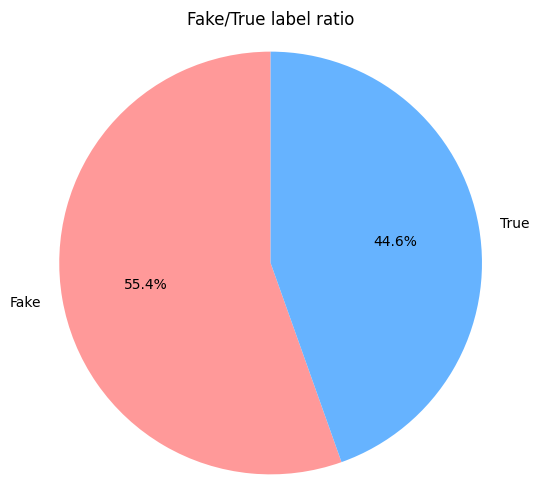

In [ ]:
label_counts = train_data['labels'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=['Fake', 'True'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Fake/True label ratio')
plt.axis('equal')
plt.show()


## **Text length distribution**

In [ ]:
# Calculate text length by number of words
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))

fake_lengths = train_data[train_data['labels'] == 0]['text_length']
real_lengths = train_data[train_data['labels'] == 1]['text_length']

# Statistics
print("Fake news (label=0):")
print(fake_lengths.describe())
print("\nTrue news (label=1):")
print(real_lengths.describe())

Fake news (label=0):
count    26145.000000
mean       436.944923
std        660.960080
min          1.000000
25%        100.000000
50%        325.000000
75%        518.000000
max      24234.000000
Name: text_length, dtype: float64

True news (label=1):
count    21009.000000
mean       530.917750
std        565.007502
min          1.000000
25%        177.000000
50%        387.000000
75%        714.000000
max      14641.000000
Name: text_length, dtype: float64


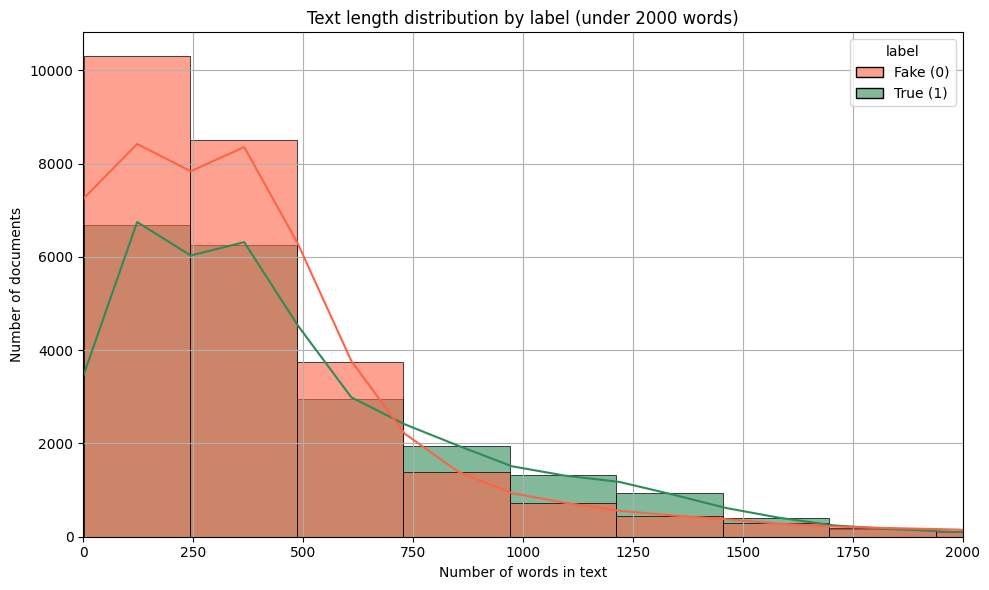

In [ ]:
df_lengths = pd.DataFrame({
    'text_length': pd.concat([fake_lengths, real_lengths], ignore_index=True),
    'label': ['Fake (0)'] * len(fake_lengths) + ['True (1)'] * len(real_lengths)})

plt.figure(figsize=(10, 6))
sns.histplot(data=df_lengths, x='text_length', hue='label',
             bins=100, kde=True, palette={'Fake (0)': 'tomato', 'True (1)': 'seagreen'}, alpha=0.6)

plt.title('Text length distribution by label (under 2000 words)')
plt.xlabel('Number of words in text')
plt.ylabel('Number of documents')
plt.xlim(0, 2000)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Word frequency analysis**

In [ ]:
#Join folder token
llm_path = os.path.join(path, 'token')

with open(os.path.join(llm_path, 'train.pkl'), 'rb') as f:
    train_tokens = pickle.load(f)

print(train_tokens[:1])

[['time', 'since', 'justice', 'antonin', 'scalias', 'passing', 'saturday', 'hardworking', 'folk', 'monkey', 'cage', 'already', 'done', 'yeoman', 'work', 'offering', 'five', 'separate', 'post', 'politics', 'volokh', 'conspiracy', 'outdone', 'post', 'topic', 'apology', 'takeaway', 'message', 'dont', 'disagree', 'single', 'thing', 'mike', 'bailey', 'wrote', 'monkey', 'cage', 'scotusblogs', 'tom', 'goldstein', 'wrote', 'game', 'strategy', 'obama', 'republican', 'senator', 'make', 'sense', 'savvy', 'political', 'supreme', 'court', 'nomination', 'process', 'sure', 'epic', 'debate', 'reading', 'however', 'one', 'small', 'teeny', 'tiny', 'detail', 'kept', 'nagging', 'matter', 'play', 'supreme', 'court', 'loses', 'hardworking', 'staff', 'spoiler', 'alert', 'banging', 'periodically', 'erosion', 'trust', 'american', 'political', 'institution', 'supreme', 'court', 'immune', 'trend', 'here', 'general', 'social', 'survey', 'data', 'fair', 'supreme', 'court', 'still', 'widely', 'respected', 'either',

In [ ]:
flat_tokens = [token for doc in train_tokens for token in doc]
total_tokens = len(flat_tokens)
print(f"Total words: {total_tokens:,}")

Total words: 12,628,144


In [ ]:
word_counter = Counter(flat_tokens)

over_01pct = sum(1 for word, count in word_counter.items() if count / total_tokens > 0.001)
over_001pct = sum(1 for word, count in word_counter.items() if count / total_tokens > 0.0001)

print(f"\nNumber of words with occurrence rate > 0.1%: {over_01pct:,}")
print(f"\nNumber of words with occurrence rate > 0.01%: {over_001pct:,}")


Number of words with occurrence rate > 0.1%: 108

Number of words with occurrence rate > 0.01%: 1,821


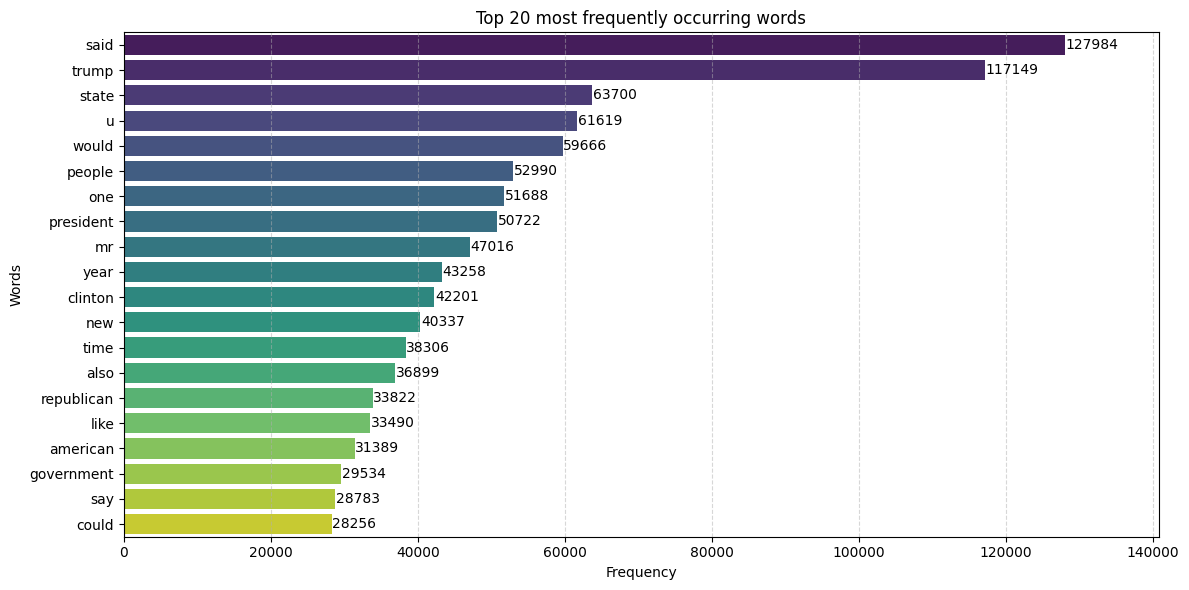

In [ ]:
most_common_20 = word_counter.most_common(20)

df_plot = pd.DataFrame(most_common_20, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x='count', y='word', hue='word', palette='viridis', legend=False)

for i, count in enumerate(df_plot['count']):
    plt.text(count + 100, i, str(count), va='center')

plt.xlim(0, df_plot['count'].max() * 1.1)
plt.title("Top 20 most frequently occurring words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

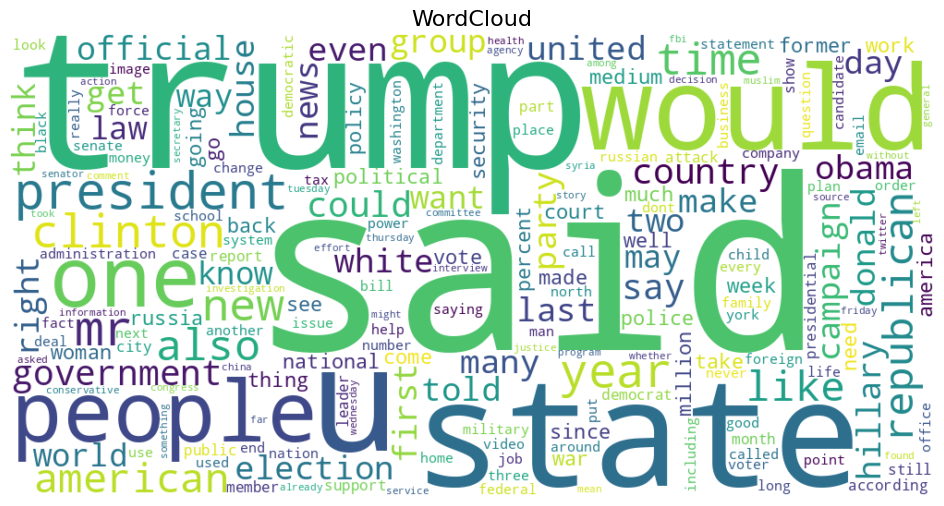

In [ ]:
# WordCloud
wc = WordCloud(width=1000, height=500, background_color='white', max_words=200).generate_from_frequencies(word_counter)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud", fontsize=16)
plt.show()

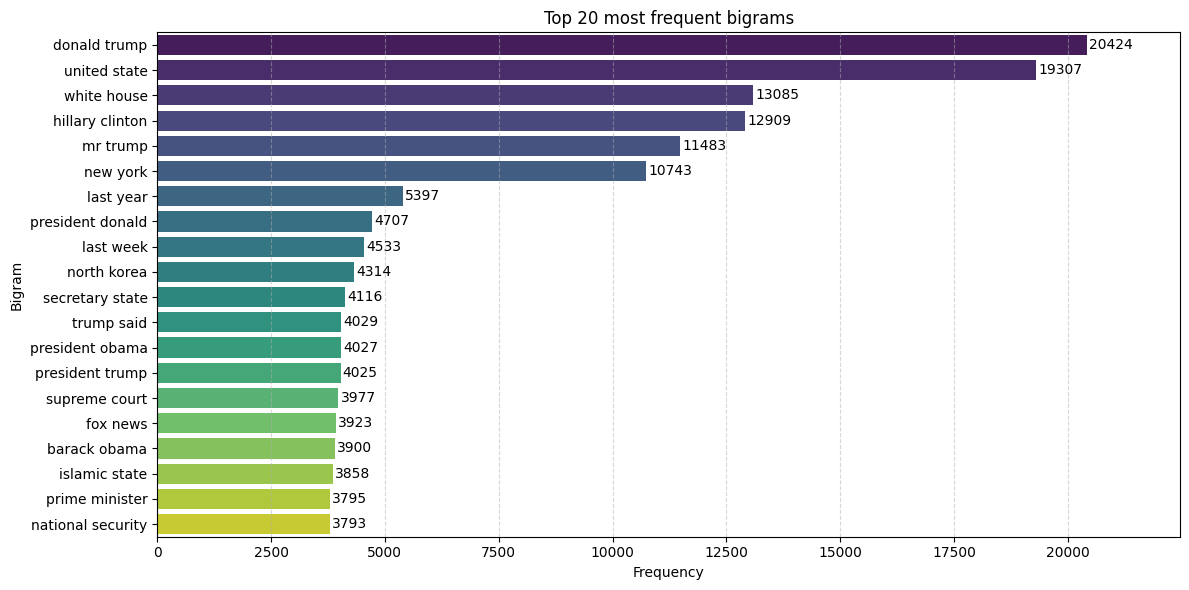

In [ ]:
#Bigram
bigram_counter = Counter(ngrams(flat_tokens, 2))
top_20_bigrams = bigram_counter.most_common(20)

df_bi = pd.DataFrame(top_20_bigrams, columns=['bigram', 'count'])
df_bi['bigram'] = df_bi['bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(12, 6))
sns.barplot(data=df_bi, x='count', y='bigram', hue='bigram', palette='viridis', dodge=False, legend=False)

for i, count in enumerate(df_bi['count']):
    plt.text(count + 50, i, str(count), va='center')

plt.xlim(0, df_bi['count'].max() * 1.1)
plt.title("Top 20 most frequent bigrams")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

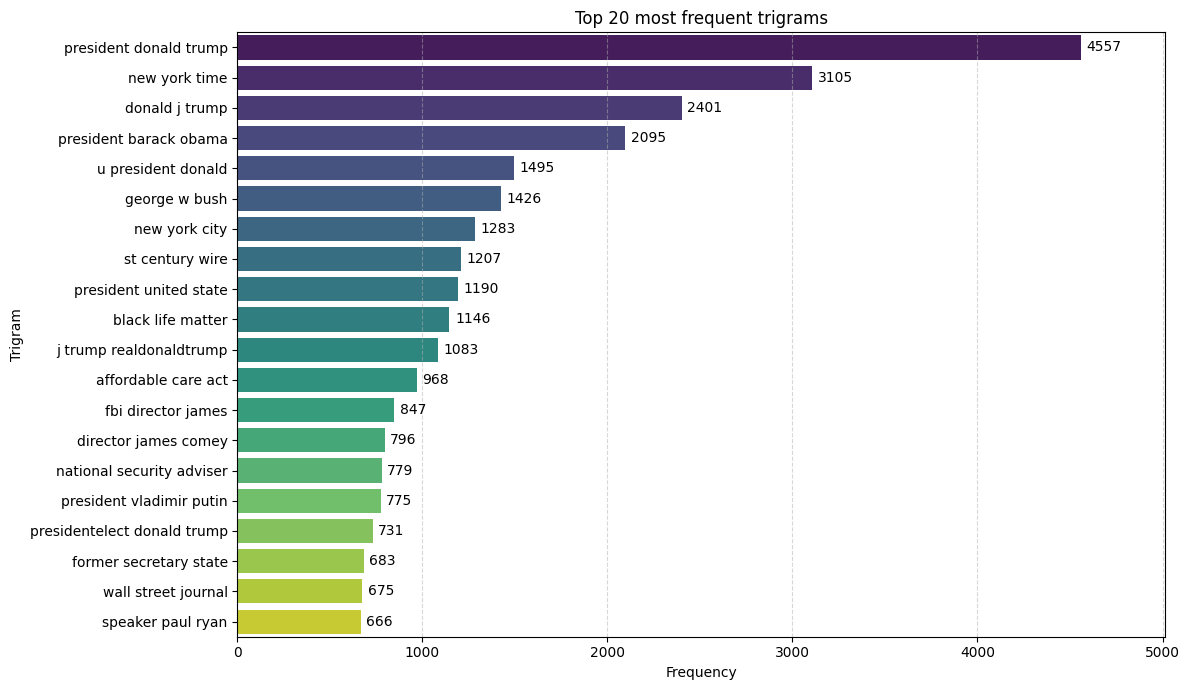

In [ ]:
#Trigram
trigram_counter = Counter(ngrams(flat_tokens, 3))
top_20_trigrams = trigram_counter.most_common(20)

df_tri = pd.DataFrame(top_20_trigrams, columns=['trigram', 'count'])
df_tri['trigram'] = df_tri['trigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(12, 7))
sns.barplot(data=df_tri, x='count', y='trigram', hue='trigram', palette='viridis', dodge=False, legend=False)

for i, count in enumerate(df_tri['count']):
    plt.text(count + 30, i, str(count), va='center')

plt.xlim(0, df_tri['count'].max() * 1.1)
plt.title("Top 20 most frequent trigrams")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()